# Проект: Анализ оттока клиентов банка.

## Описание проекта.

Цель — провести анализ оттока клиентов и подготовить план действий по удержанию клиентов в будущем.

Задачи:
    - сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
    - выявить и проанализировать основные признаки, наиболее сильно влияющие на отток;
    - сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами (выделить сегменты клиентов, предложить меры по снижению оттока в будущем).
    
Источник информации: предоставленная заказчиком csv-таблица, содержащая данные о балансе, кредитном скоринге, возрасте, доходе, характере взаимодействия с банком.

Структура проекта:
1. [Изучение данных.](#start)
2. [Предобработка данных.](#preprocessing)
2. [Исследовательский анализ данных.](#eda)
4. [Проверка гипотез.](#hypothesis)
3. [Создание модели прогнозирования оттока клиентов и определение ключевых признаков для сегментирования.](#model_creation)
4. [Сегментирование клиентов.](#segments)
5. [Выводы и рекомендации.](#outcome)

In [211]:
#Библиотеки для работы с данными
import pandas as pd
import numpy as np
from scipy import stats as st

#Библиотеки для визуализации данных
import seaborn as sns
import matplotlib.pyplot as plt

#Импортирую модули библиотеки sklearn для машинного обучения и проверки метрик
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

## Изучение данных.
<a id="start"></a>

In [212]:
# чтение файла bank_scrooge.csv с данными и сохранение его в переменную 
path = "https://drive.google.com/uc?export=download&id=1-U61mhTz_N1ARjy2XSAZ7IlQqGjeqP0F" 
data = pd.read_csv(path)

In [213]:
display(data.head())
data['equity'].unique()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


array([1, 5, 0, 4, 3, 2, 6, 7, 8, 9], dtype=int64)

In [214]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


## Предобработка данных.
<a id="preprocessing"></a>

### Редактирование названий колонок

In [215]:
data.columns = data.columns.str.lower()
data.rename(columns = {'userid':'user_id'}, inplace = True)
data.head()
display(data['city'])

0         Рыбинск
1         Рыбинск
2         Рыбинск
3       Ярославль
4       Ярославль
          ...    
9995      Рыбинск
9996    Ярославль
9997    Ярославль
9998    Ярославль
9999      Рыбинск
Name: city, Length: 10000, dtype: object

### Кодирование категориальных переменных.

In [216]:
#Создаю временную таблицу для работы
#Создаю копии столбцов, данные которых буду кодировать
temp = data.copy()
temp['city_copy'] = data['city']
temp['gender_copy'] = data['gender']
temp = pd.get_dummies(temp, columns=['city_copy', 'gender_copy'], drop_first=False)
temp.rename(columns = {'city_copy_Ростов':'rostov', 'city_copy_Рыбинск': 'rybinsk', 'city_copy_Ярославль': 'yaroslavl', 'gender_copy_Ж': 'gender_f', 'gender_copy_М': 'gender_m'}, inplace = True )
display(temp)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_f,gender_m
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0,0,1,0,0,1
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0,0,0,1,0,1
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0,0,0,1,0,1
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0,0,0,1,1,0


### Поиск и удаление дубликатов.

In [217]:
display(temp.duplicated().sum())
display(temp['user_id'].duplicated().sum())
temp = temp.drop_duplicates(subset=['user_id'], keep='first')
temp = temp.reset_index(drop=True)
#display(temp['user_id'].duplicated().sum())

0

73

Найдено 73 дубликата user_id. Оставлены в таблице только первые вхождения.

### Обработка пропусков.

In [218]:
#Создаю таблицу для обработки пропусков
temp_gap = temp.copy()

In [219]:
#Создаю переменную, содержащую информацию о наличии пропусков
balance_gap = []

for i in temp_gap['balance']:
    if np.isnan(i):
        balance_gap.append(1)
    else:
        balance_gap.append(0)

In [220]:
#На основе переменной balance_gap создаю колонку с индикатором наличия пропусков
temp_gap['balance_gap'] = balance_gap
display(temp.head())

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_f,gender_m
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


In [221]:
#Группирую данные по наличию пропусков в столбце balance, чтобы посмротреть, насколько отличаются для них средние значения по признакам
temp_group = temp_gap.groupby('balance_gap').mean().round(2).drop(['user_id'], axis = 1)
display(temp_group)

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_f,gender_m
balance_gap,,,,,,,,,,,,,,
0,843.84,42.91,3.40,828901.61,2.08,0.64,0.52,124660.86,0.24,0.15,0.27,0.57,0.52,0.48
1,865.33,42.13,0.05,NaN,1.16,0.82,0.55,226700.56,0.01,0.10,0.25,0.64,0.44,0.56


Самые большие различия по средним значениям признаков видны в столбцах: equity, products, est_salary, churn. Данные о балансе неизвестны для людей с более высоким оценочным доходом, которые при этом имеют меньше баллов собственности и меньше пользуются продуктами банка. Данные выглядят противоречивыми. Пока сложно утверждать, что в пропусках в balance есть закономерность, связанная с самими этими данными.
Прежде чем утверждать, что мы имеем дело с пропусками какого-то определённого типа , проверим результат при помощи графиков.

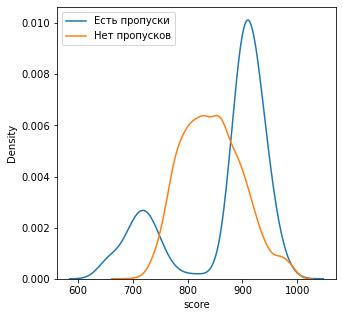

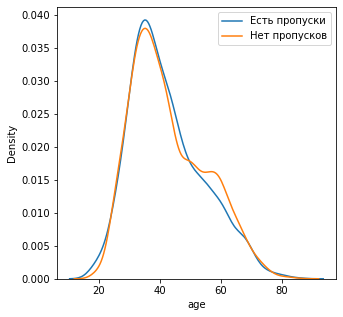

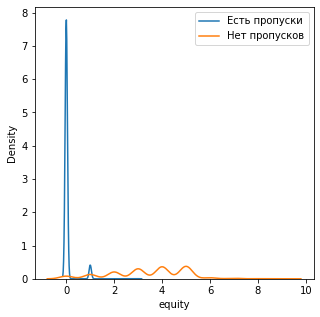

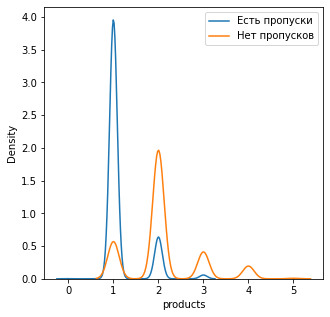

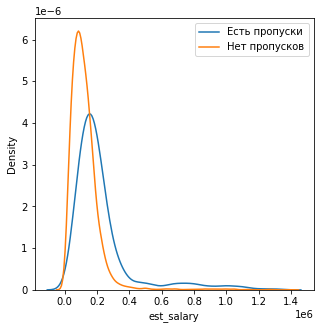

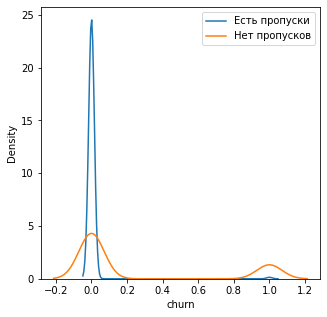

In [222]:
#Для создания гистограмм и графиков распределения создаём таблицы с данными отдельно для строк с пропущенными и непропущенными данными.
is_balance_gap = temp_gap.query('balance_gap == 1')
no_balance_gap = temp_gap.query('balance_gap == 0')

for column in ['score', 'age', 'equity', 'products', 'est_salary', 'churn']:
    plt.figure(figsize=(5, 5))
    sns.kdeplot(is_balance_gap[column], label = 'Есть пропуски')
    sns.kdeplot(no_balance_gap[column], label = 'Нет пропусков')
    plt.legend()
    plt.show()



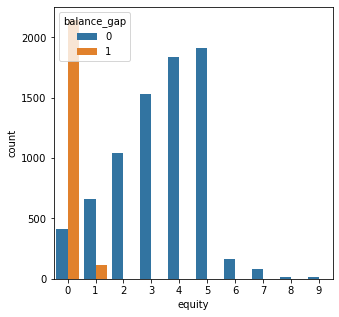

In [223]:
plt.figure(figsize=(5, 5))
sns.countplot(x = temp_gap['equity'], hue='balance_gap', data=temp_gap)
plt.show()



Судя по графикам, пропуски влияют на данные в колонках: score (при том, что средние значения для тех, данные о балансе которых отсутствуют, и тех, для кого такие данные есть, не различаются), equity (что по-своему странно, поскольку в представленных данных это показатель выше у группы без пропусков в балансе, у которых при этом оценка дохода в среднем в два раза ниже, чем у тех, для кого данные о балансе отсутствуют). Данные о балансе чаще всего пропущенны для тех, кто использует один продукт. Немного чаще данные о балансе отсутствуют для тех, у кого больше оценочный доход.

Что касается колонок с бинарными данными:
По городам видно, что доля пропусков для Ростове несколько меньше чем для Ярославля и Рыбинска. Для тех, кто пользуется кредитной картой банка доля пропусков выше, чем для тех, кто кредитной картой не пользуется. Немного чаще пропущенные данные есть у мужчин.

Очень большая разница по этому показателю между отточными и удержанными клиентами. Однако, эта разница - в пользу удержанных клиентов.
Обилие пропусков может быть связано с характеристикой equity внутри наших данных. Люди, у которых практически нет баллов собственности, не имеют информации о балансе. Здесь есть взаимосвязь, характер которой неочевиден.
Отличается распределение с пропусками в balance от распределения без пропусков по столбцу score. Здесь распределение имеет два пика: с низким показателем score и с высоким. Такая ситуация очевидно связана с какой-то внешней причиной.
Очевидно, мы имеем дело с пропусками, на которые влияют факторы, отсутствующие в наших данных. Пропуски относятся к типу MNAR (Missing Not At Random / Отсутствует не случайно).
Заполнять такие пропуски какими-то значениями в любом случае не было бы смысла. В столбце balance очень много пропусков, поставим "заглушку" в виде числа -0.1, которую будем убирать при рассчётах.

In [224]:
display(temp.head())
#display(temp.isna().sum())
#temp['balance'].value_counts()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_f,gender_m
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


In [225]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9927 entries, 0 to 9926
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9927 non-null   int64  
 1   score          9927 non-null   float64
 2   city           9927 non-null   object 
 3   gender         9927 non-null   object 
 4   age            9923 non-null   float64
 5   equity         9927 non-null   int64  
 6   balance        7667 non-null   float64
 7   products       9927 non-null   int64  
 8   credit_card    9927 non-null   int64  
 9   last_activity  9927 non-null   int64  
 10  est_salary     9927 non-null   float64
 11  churn          9927 non-null   int64  
 12  rostov         9927 non-null   uint8  
 13  rybinsk        9927 non-null   uint8  
 14  yaroslavl      9927 non-null   uint8  
 15  gender_f       9927 non-null   uint8  
 16  gender_m       9927 non-null   uint8  
dtypes: float64(4), int64(6), object(2), uint8(5)
memory 

In [226]:
#Убираю строки с пустыми значениями колонки age
temp = temp.dropna(subset = ['age']).reset_index()

In [227]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9923 entries, 0 to 9922
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          9923 non-null   int64  
 1   user_id        9923 non-null   int64  
 2   score          9923 non-null   float64
 3   city           9923 non-null   object 
 4   gender         9923 non-null   object 
 5   age            9923 non-null   float64
 6   equity         9923 non-null   int64  
 7   balance        7663 non-null   float64
 8   products       9923 non-null   int64  
 9   credit_card    9923 non-null   int64  
 10  last_activity  9923 non-null   int64  
 11  est_salary     9923 non-null   float64
 12  churn          9923 non-null   int64  
 13  rostov         9923 non-null   uint8  
 14  rybinsk        9923 non-null   uint8  
 15  yaroslavl      9923 non-null   uint8  
 16  gender_f       9923 non-null   uint8  
 17  gender_m       9923 non-null   uint8  
dtypes: float

## Исследовательский анализ данных.
<a id="eda"></a>

### Изучаем средние значения признаков (в т.ч. в разрезе оттока).

In [228]:
def column_len(table, column):
    table_column_len = len(table.columns)
    
    return table.iloc [:, 2:table_column_len].describe().round(2)
    


temp_column_len = len(temp.columns)
display(temp.iloc [:, 2:temp_column_len].describe().round(2))

display(column_len(temp, 2))

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_f,gender_m
count,9923.00,9923.00,9923.00,7.663000e+03,9923.00,9923.00,9923.00,9923.00,9923.00,9923.00,9923.00,9923.00,9923.0,9923.0
mean,848.73,42.73,2.63,8.282482e+05,1.87,0.68,0.52,147886.49,0.18,0.14,0.27,0.59,0.5,0.5
std,65.40,12.18,1.98,1.984248e+06,0.79,0.47,0.50,139363.90,0.39,0.35,0.44,0.49,0.5,0.5
min,642.00,18.00,0.00,0.000000e+00,0.00,0.00,0.00,2546.30,0.00,0.00,0.00,0.00,0.0,0.0
25%,802.00,33.00,0.00,2.954990e+05,1.00,0.00,0.00,75252.12,0.00,0.00,0.00,0.00,0.0,0.0
50%,853.00,40.00,3.00,5.249612e+05,2.00,1.00,1.00,119719.33,0.00,0.00,0.00,1.00,0.0,1.0
75%,900.00,51.00,4.00,9.808015e+05,2.00,1.00,1.00,174673.28,0.00,0.00,1.00,1.00,1.0,1.0
max,1000.00,86.00,9.00,1.191136e+08,5.00,1.00,1.00,1395064.45,1.00,1.00,1.00,1.00,1.0,1.0


,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_f,gender_m
count,9923.00,9923.00,9923.00,7.663000e+03,9923.00,9923.00,9923.00,9923.00,9923.00,9923.00,9923.00,9923.00,9923.0,9923.0
mean,848.73,42.73,2.63,8.282482e+05,1.87,0.68,0.52,147886.49,0.18,0.14,0.27,0.59,0.5,0.5
std,65.40,12.18,1.98,1.984248e+06,0.79,0.47,0.50,139363.90,0.39,0.35,0.44,0.49,0.5,0.5
min,642.00,18.00,0.00,0.000000e+00,0.00,0.00,0.00,2546.30,0.00,0.00,0.00,0.00,0.0,0.0
25%,802.00,33.00,0.00,2.954990e+05,1.00,0.00,0.00,75252.12,0.00,0.00,0.00,0.00,0.0,0.0
50%,853.00,40.00,3.00,5.249612e+05,2.00,1.00,1.00,119719.33,0.00,0.00,0.00,1.00,0.0,1.0
75%,900.00,51.00,4.00,9.808015e+05,2.00,1.00,1.00,174673.28,0.00,0.00,1.00,1.00,1.0,1.0
max,1000.00,86.00,9.00,1.191136e+08,5.00,1.00,1.00,1395064.45,1.00,1.00,1.00,1.00,1.0,1.0


Среди клиентов приблизительно поровну мужчин и женщин. Распределение долей клиентов по городам приблизительно соответствует соотношению численности населения этих городов на 2021 г.
Отток составляет 24% числа клиентов после удаления дубликатов user_id.
Медианное и среднее значения по зарплате отличаются довольно значительно (медиана составляет 0.8533 от средней),следовательно, можно ожидать заметного выброса по этому параметру.
Больше половины (52%) клиентов пользовались услугами банка в течение последнего месяца. В средне 64% клиентов имеют хотя бы одну кредитную карту банка. На каждого клиента приходится в среднем чуть более двух пакетов услуг.
Медианное значение баланса относится к среднему как 0.634. Следовательно, этот показатель среди тех клиентов, о балансе которых нам известно, имеет большую долю выбросов.
Основная масса имеет от 2-х до 5-ти баллов собственности. Здесь нет большого разброса: медиана (4) и среднее (3.4) отличаются не сильно. Возраст основной массы клиентов колеблется в промежутке 33-52 лет, т.е., это люди трудоспособного возраста.
Ниже посмотрим, насколько отличаются показатели в разрезе оттока.

In [229]:
#Смотрим данные для удержанных.
temp_retention = temp[temp['churn'] == 0]
display(column_len(temp_retention, 2))

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_f,gender_m
count,8104.00,8104.00,8104.00,5.857000e+03,8104.00,8104.00,8104.00,8104.00,8104.0,8104.00,8104.00,8104.00,8104.00,8104.00
mean,845.44,43.02,2.38,7.338286e+05,1.76,0.71,0.48,147795.99,0.0,0.14,0.27,0.58,0.53,0.47
std,68.01,12.37,1.97,1.959055e+06,0.71,0.45,0.50,142799.30,0.0,0.35,0.45,0.49,0.50,0.50
min,642.00,18.00,0.00,0.000000e+00,1.00,0.00,0.00,2546.30,0.0,0.00,0.00,0.00,0.00,0.00
25%,796.00,34.00,0.00,2.790048e+05,1.00,0.00,0.00,73487.07,0.0,0.00,0.00,0.00,0.00,0.00
50%,848.00,40.00,3.00,4.753548e+05,2.00,1.00,0.00,118248.52,0.0,0.00,0.00,1.00,1.00,0.00
75%,900.00,51.00,4.00,8.538264e+05,2.00,1.00,1.00,174106.04,0.0,0.00,1.00,1.00,1.00,1.00
max,1000.00,86.00,9.00,1.191136e+08,5.00,1.00,1.00,1395064.45,0.0,1.00,1.00,1.00,1.00,1.00


Среди удержанных клиентов значительно больше женщин (57%). Распределение по городам практически не отличается от показателей для всех клиентов в целом.
Средняя и медианная зарплата для удержанных меньше, чем для всей совокупности клиентов банка. Отношение медианы по зарплате к среднему составляет 0.86 и практически не отличается от такого отношения для всех клиентов.
Услугами банка за последний месяц пользовались 46% клиентов, что меньше среднего показателя для общей их массы. 
В среднем 67% удержанных пользуются кредитной картой банка, что так же не отличается от общего показателя.
Среднее значение пользования продуктами здесь непринципиально ниже. Можно так же говорить о двух продуктах на каждого клиента.
Медианное значение баланса относится к среднему как 0.648. Следовательно, этот показатель среди тех клиентов, о балансе которых нам известно, имеет большую долю выбросов. Разница значений в этом срезе так же больше, чем для клиентов в целом.
Основная масса клиентов в этом срезе имеет от 2-х до 5-ти баллов собственности. Но средний и медианный показатели здесь ниже, чем в целом для всех клиентов банка (3.27 и 3 соответственно, против 4 и 3.4 баллов). Среднее по срезу в этом признаке отличается от среднего в целом сильнее, чем медианы, при почти равном (1.57 и 1.58) стандартном отклонении. Возможно, есть большой выброс в этом показателе для уходящих.
Возраст основной массы удержанных клиентов колеблется в интервале 34-52 года, что практически не отличается от показателя для всех клиентов.

In [230]:
#Смотрим данные для ушедших.
temp_churn = temp[temp['churn'] == 1]
display(column_len(temp_churn, 2))

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_f,gender_m
count,1819.00,1819.00,1819.00,1806.00,1819.00,1819.00,1819.00,1819.00,1819.0,1819.00,1819.00,1819.00,1819.00,1819.00
mean,863.42,41.45,3.76,1134458.21,2.38,0.55,0.70,148289.70,1.0,0.15,0.24,0.61,0.35,0.65
std,49.62,11.18,1.59,2034445.55,0.92,0.50,0.46,122932.16,0.0,0.35,0.43,0.49,0.48,0.48
min,706.00,18.00,0.00,6.00,0.00,0.00,0.00,10880.27,1.0,0.00,0.00,0.00,0.00,0.00
25%,828.00,32.00,3.00,387482.16,2.00,0.00,0.00,83196.61,1.0,0.00,0.00,0.00,0.00,0.00
50%,866.00,39.00,4.00,783908.90,2.00,1.00,1.00,125395.22,1.0,0.00,0.00,1.00,0.00,1.00
75%,898.00,52.00,5.00,1348127.55,3.00,1.00,1.00,175985.38,1.0,0.00,0.00,1.00,1.00,1.00
max,1000.00,79.00,9.00,64866210.15,5.00,1.00,1.00,1263028.49,1.0,1.00,1.00,1.00,1.00,1.00


65% всех ушедших - мужчины.
Распределение по городам не имеет принципиального отличия от двух предыдущих примеров.
Средний и медианный показатель по заработной плате в оттоке выше, чем среди удержанных и чем в среднем среди всех клиентов банка. Отношение медианы по зарплате к среднему составляет 0.85 и практически не отличается от такого отношения для клиентов в обоих предыдущих случаях.
За последний месяц среди отточных услугами банка пользовались 71% клиентов, что значительно выше среднего для всех пользователей. Разница с удержанными пользователями ещё больше (71% против 46%). Можно уже предположить, что у банка уходят наиболее активные клиенты.
При этом отточные клиенты реже пользовались кредитными картами: 55% против 67% среди удержанных и 64% среди всех клиентов банка.
В среднем эта категория клиентов пользовалась 2.38 продукта, что так же выше показателей в двух предыдущих случаях.
Среднее и медианное (особенно) значение баланса здесь выше, чем для удержанных и в целом для всех клиентов. Медианное значение баланса относится к среднему как 0.69.
Основная масса клиентов в этом срезе имеет от 2-х до 5-ти баллов собственности. Нижняя граница показателя на 1 выше, чем для удержанных и для всех клиентов в целом. Средний и медианный показатели выше, а разница между ними меньше (3.79 и 4 соответственно). Если для удержанных средний показатель в этом признаке выше медианного, то среди ушедших - наоборот. Это странно. Все значения в таблице для ушедших больше, но тот факт. что медиана здесь больше говорит о наличии для этой группы клиентов малых величин по собственности.
Возраст основной массы клиентов в этой группе 32-52 года. Средний возраст на 2 года ниже, чем среди удержанных и на полтора года ниже, чем всреднем для всех клиентов банка.
Кредитный скоринг, как средний, так и медианный у них выше, чем у удержанных и у среднего клиента в целом.

В целом можно уже предположить основные характеристики отточных клиентов.
Чаще всего это мужчины в среднем в возрасте в 41 год. Они моложе удержанных клиентов, хоть и незначительно. Они были более активными клиентами, пользовались бОльшим количеством продуктов, имели больший доход и больший баланс, а так же большее количество баллов собственности. Средний и медианный кредитный скоринг так же больше.
Похоже, банк теряет главным образом ценных клиентов.

ВЫбросы очень серьёзные, но убирать их в силу специфики бизнеса нет необходимости. Очевидно, речь идёт о VIP-клиентах, имеющих большое значение для банка. для банка

### Графики распределения признаков для удержанных и ушедших клиентов.

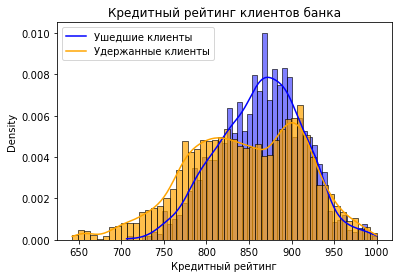

In [231]:
#Строим гисторгамму для сравнения критерия score по обеим группам.
ax = sns.histplot(temp_churn['score'], common_norm=False, stat = "density", kde=True, bins = 50, color = 'blue')
sns.histplot(temp_retention['score'], common_norm=False, stat = "density", kde=True, bins = 50, color="orange", alpha = 0.7)
plt.title('Кредитный рейтинг клиентов банка')
ax.set(xlabel='Кредитный рейтинг')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()


Уходят клиенты, имеющие score 830 до 950.

Строю графики без применения цикла, чтобы их можно было подписать для презентации.

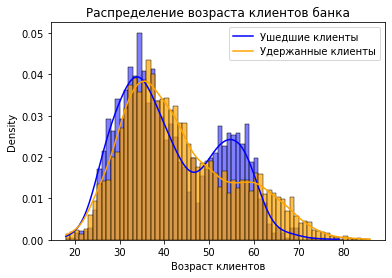

In [232]:
#Строим гисторгамму для сравнения критерия age по обеим группам.
ax = sns.histplot(temp_churn['age'], stat = "density", kde=True, bins = 50, color = 'blue', binwidth = 1)
sns.histplot(temp_retention['age'], stat = "density", kde=True, bins = 50, color="orange", alpha = 0.7, binwidth = 1)
plt.title('Распределение возраста клиентов банка')
ax.set(xlabel='Возраст клиентов')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()



Уходят клиенты возрасте от 25 до 38 лет и от 50 до 61 лет ориентировочно.

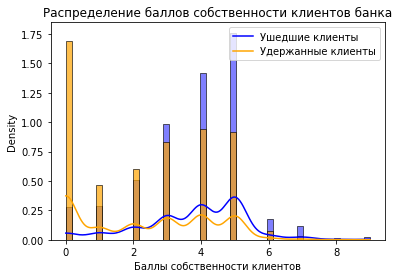

In [233]:
#Строим гисторгамму для сравнения критерия equity по обеим группам.
ax = sns.histplot(temp_churn['equity'], stat = "density", kde=True, bins = 50, color = 'blue')
sns.histplot(temp_retention['equity'], stat = "density", kde=True, bins = 50, color="orange", alpha = 0.7)
plt.title('Распределение баллов собственности клиентов банка')
ax.set(xlabel='Баллы собственности клиентов')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()


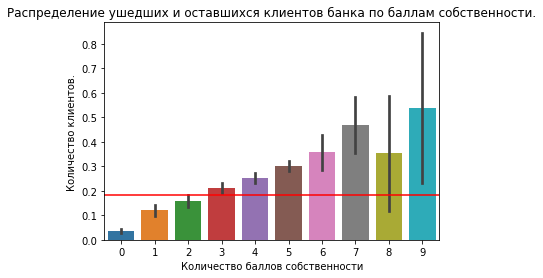

In [234]:
temp_group = temp.groupby('equity').agg({'churn':'mean'})
#display(temp_group)
sns.barplot(x="equity", y = "churn", data=temp).axhline(temp.churn.mean(),c='red')
plt.title('Распределение ушедших и оставшихся клиентов банка по баллам собственности.')
plt.xlabel('Количество баллов собственности')
plt.ylabel('Количество клиентов.')
plt.show()

Основной отток свойствен клиентам с количеством баллов собственности от 3 до 9. В основном прослеживается тенденция, согласно которой, чем больше баллов собственности, тем выше уровень оттока.

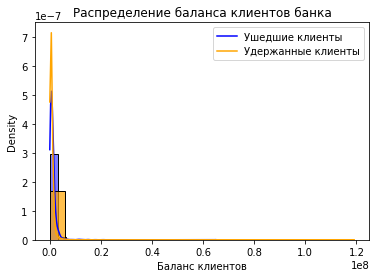

In [235]:
#Строим гисторгамму для сравнения критерия balance по обеим группам.
ax = sns.histplot(temp_churn['balance'], common_norm=False, stat = "density", kde=True, bins = 20, color = 'blue')
sns.histplot(temp_retention['balance'], common_norm=False, stat = "density", kde=True, bins = 20, color="orange", alpha = 0.7)
plt.title('Распределение баланса клиентов банка')
ax.set(xlabel='Баланс клиентов')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()

График малоинформативный. Однако, можно утверждать, что баланс ушедших клиентов выше. Посмотрим на количество выбросов по балансу.

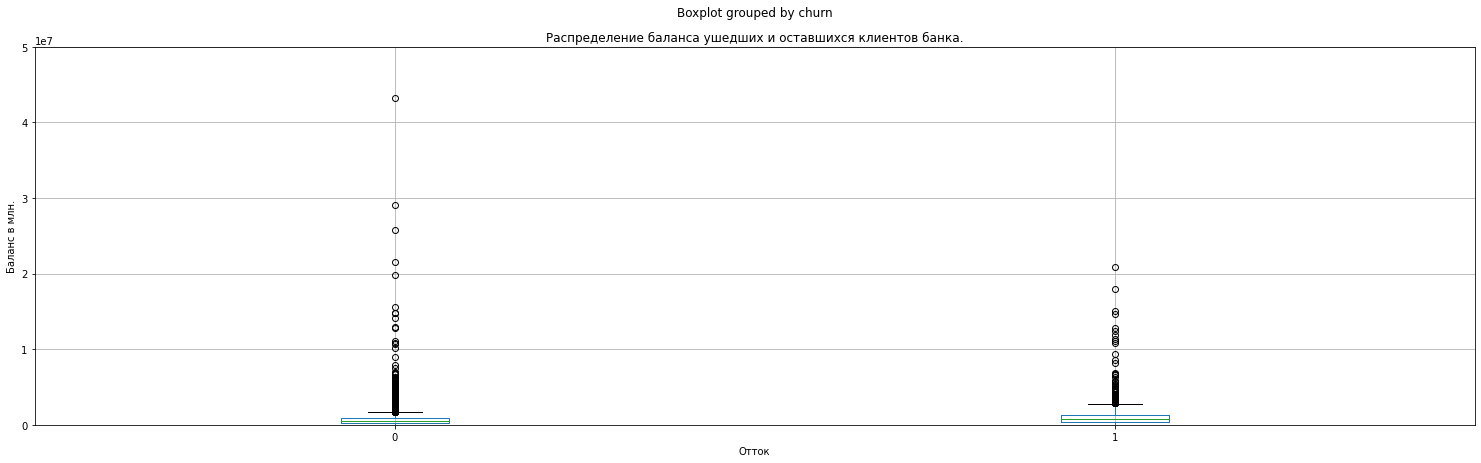

In [236]:
temp.boxplot(column='balance', by='churn', grid=True, figsize=(25,7))
plt.title('Распределение баланса ушедших и оставшихся клиентов банка.')
plt.xlabel('Отток')
plt.ylabel('Баланс в млн.')
plt.ylim(0, 50000000)
plt.show()

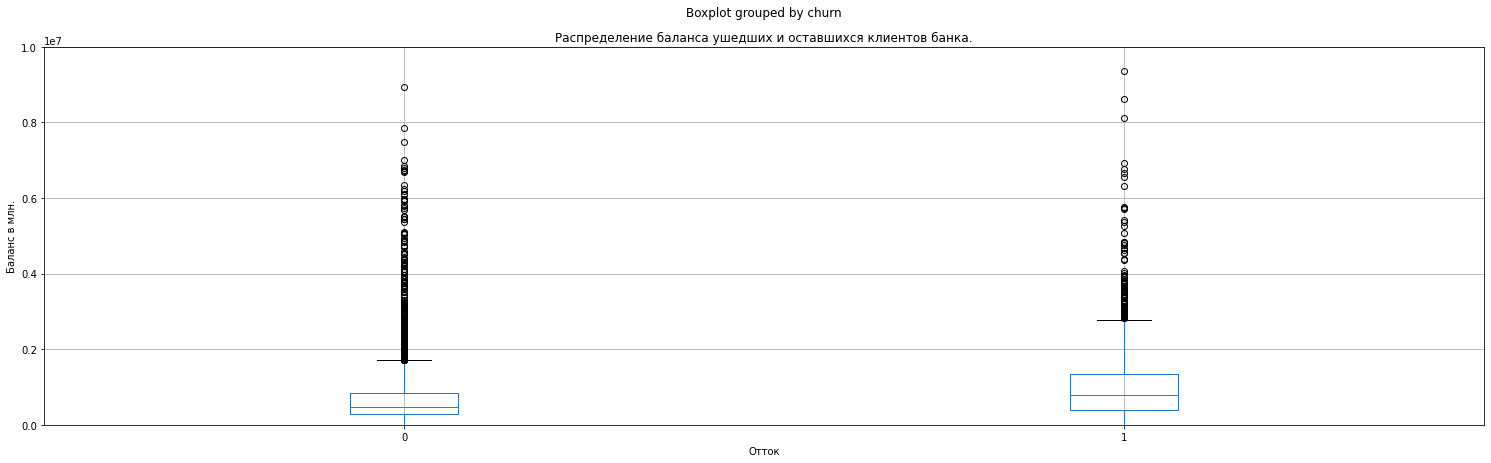

In [237]:
temp.boxplot(column='balance', by='churn', grid=True, figsize=(25,7))
plt.title('Распределение баланса ушедших и оставшихся клиентов банка.')
plt.xlabel('Отток')
plt.ylabel('Баланс в млн.')
plt.ylim(0, 10000000)
plt.show()

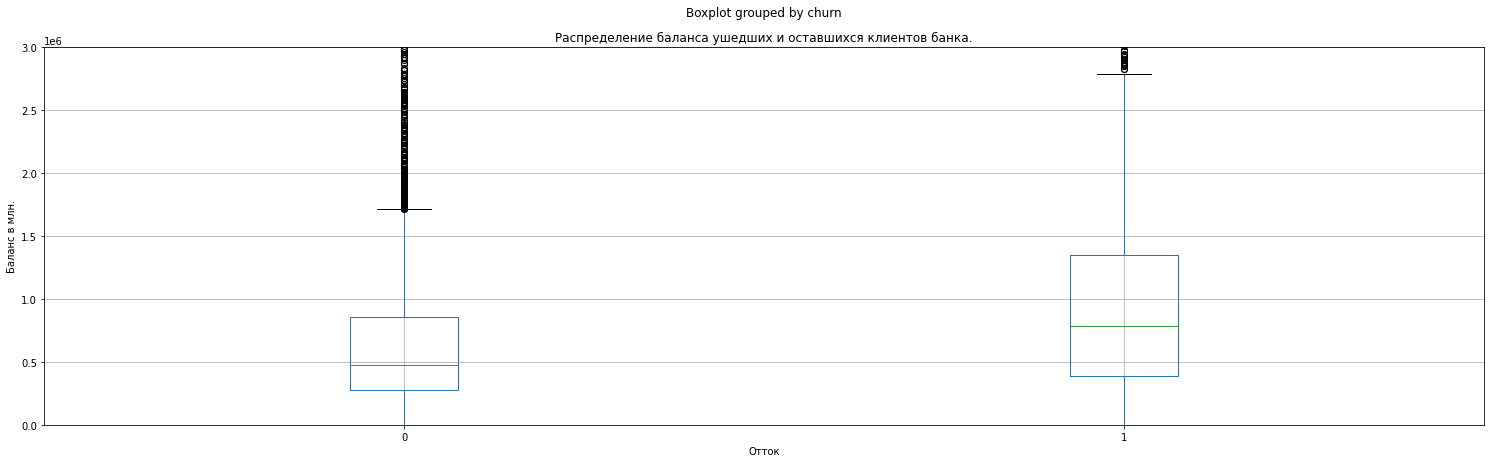

In [238]:
temp.boxplot(column='balance', by='churn', grid=True, figsize=(25,7))
plt.title('Распределение баланса ушедших и оставшихся клиентов банка.')
plt.xlabel('Отток')
plt.ylabel('Баланс в млн.')
plt.ylim(0, 3000000)
plt.show()

В обоих случаях большую роль играют выбросы, которые мы сохраняем в силу специфики бизнеса. VIP-клиенты с большим балансом очень важны для банка.
Однако медианное значение баланса основной массы ушедших больше, чем у тех, кто остался. Таже ситуация с клиентами в первой и третьей квартилях. Следовательно баланс основной массы ушедших больше, чем баланс основной массы удержанных.
Большинство ушедших имеет баланс от 400 тыс. до почти 1.5 млн. Статистически значимыми являются ушедшие клиенты с балансои до 2.8 млн.

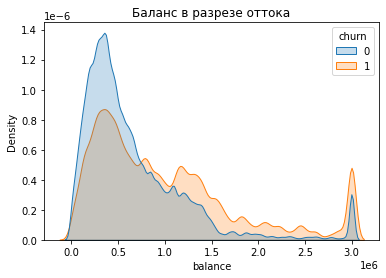

In [276]:
sns.kdeplot(data=data.assign(balance=data.balance.clip(0,3e6)), 
                    x='balance', hue='churn',
                    common_norm=False, bw_adjust=1/4, fill=True)\
    .set(title=f'''Баланс в разрезе оттока''');

Клиенты наиболее вероятно уходят начиная с уровня баланса в 750000.

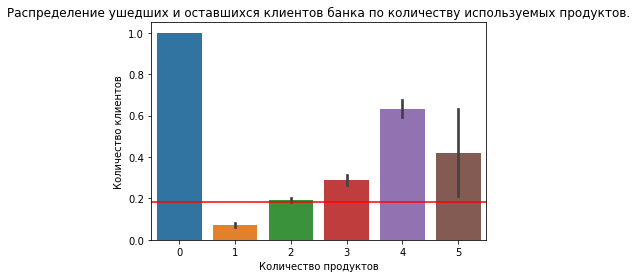

In [242]:
#Строим гисторгамму для сравнения критерия products по обеим группам.
sns.barplot(x="products", y = "churn", data=temp).axhline(temp.churn.mean(),c='red')
plt.title('Распределение ушедших и оставшихся клиентов банка по количеству используемых продуктов.')
plt.xlabel('Количество продуктов')
plt.ylabel('Количество клиентов')
plt.show()

Самый большой отток показывают клиенты, которые вообще не пользуются продуктами банка. Возможно их банк не устроил сразу (характеристики продуктов или качество обслуживания) и они уходят даже не приобретая продукты. Отток выше среднего у пользователей от 2-х до 5-ти продуктов. Здесь есть тенденция к росту оттока с ростом числа используемых продуктов.

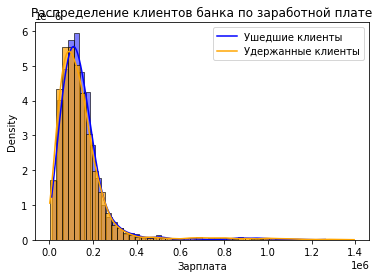

In [243]:
#Строим гисторгамму для сравнения критерия est_salary по обеим группам.
ax = sns.histplot(temp_churn['est_salary'], common_norm=False, stat = "density", kde=True, bins = 50, color = 'blue')
sns.histplot(temp_retention['est_salary'], common_norm=False, stat = "density", kde=True, bins = 50, color="orange", alpha = 0.7)
plt.title('Распределение клиентов банка по заработной плате')
ax.set(xlabel='Зарплата')
ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
plt.show()



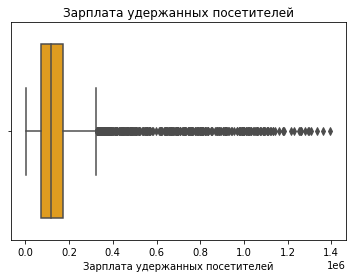

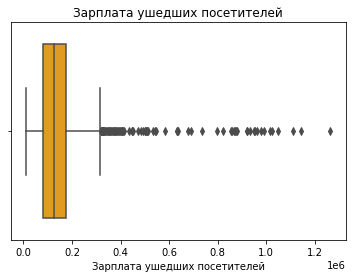

In [244]:
#Строим boxplot для сравнения критерия est_salary по обеим группам и определения выброса.
sns.boxplot(x = 'est_salary', data = temp_retention, color="orange")
plt.title('Зарплата удержанных посетителей')
plt.xlabel('Зарплата удержанных посетителей')

plt.show()


sns.boxplot(x = 'est_salary', data = temp_churn, color="orange")
plt.title('Зарплата ушедших посетителей')
plt.xlabel('Зарплата ушедших посетителей')
plt.show()

Зарплата ушедших достаточно заметно отличается. В обоих случаях мы видим большое количество выбросов. В том числе с очень большими значениями. Как, я написал выше, я не убираю эти данные, так как для банка именно эти клиенты могут иметь наибольшее значение.

### Считаем долю ушедших клиентов для бинарных признаков.

In [245]:
#Доля оттока по городам.
share_by_city = temp.query('churn == 1').groupby('city')['user_id'].count() / temp.groupby('city')['user_id'].count()
display(share_by_city.sort_values(ascending = False))
#Строим гисторгамму для сравнения критерия city по обеим группам.
#ax = sns.histplot(temp_churn['city'], common_norm=False, stat = "density", kde=True, bins = 50, color = 'blue')
#sns.histplot(temp_retention['city'], common_norm=False, stat = "density", kde=True, bins = 50, color="orange", alpha = 0.7)
#plt.title('Распределение клиентов банка по городам')
#ax.set(xlabel='Город')
#ax.legend(['Ушедшие клиенты', 'Удержанные клиенты'])
#plt.show()

city
Ярославль    0.190810
Ростов       0.187147
Рыбинск      0.164719
Name: user_id, dtype: float64

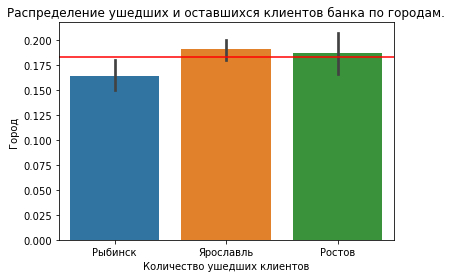

In [246]:
sns.barplot(x="city", y = "churn", data=temp).axhline(temp.churn.mean(),c='red')
plt.title('Распределение ушедших и оставшихся клиентов банка по городам.')
plt.xlabel('Количество ушедших клиентов')
plt.ylabel('Город')
plt.show()

В Ярославле и Ростове отток клиентов выше среднего. Это отточные города. Самая высокая доля оттока по городам - в Ярославле (в самом крупном городе). Рыбинск - единственный неотточный город.

In [247]:
#Строим гисторгамму для сравнения критерия credit_card по обеим группам.
share_by_credit_card = temp.query('churn == 1').groupby('credit_card')['user_id'].count() / temp.groupby('credit_card')['user_id'].count()
display(share_by_credit_card.sort_values(ascending = False))


credit_card
0    0.257008
1    0.148637
Name: user_id, dtype: float64

Диаграммы для бинарных признаков не строим. Считаем долю ушедших клиентов по каждому признаку, чтобы определить критерий оттока.
Доля тех у кого нет кредитной карты среди ушедших выше. Вероятный критерий оттока - отсутствие у клиента кредитной карты банка.

In [248]:
#Строим гисторгамму для сравнения критерия last_activity по обеим группам.
share_by_last_activity = temp.query('churn == 1').groupby('last_activity')['user_id'].count() / temp.groupby('last_activity')['user_id'].count()
display(share_by_last_activity.sort_values(ascending = False))

last_activity
1    0.245908
0    0.114588
Name: user_id, dtype: float64

Из банка ушли 11.5% тех клиентов, у кого небыло активности в течение последнего месяца и почти 25% тех, кто был в последний месяц активен. Активные уходят чаще. Это - критерий отттока в данном случае.

In [249]:
#Строим гисторгамму для сравнения критерия gender по обеим группам.
share_by_gender = temp.query('churn == 1').groupby('gender')['user_id'].count() / temp.groupby('gender')['user_id'].count()
display(share_by_gender.sort_values(ascending = False))

gender
М    0.238028
Ж    0.128407
Name: user_id, dtype: float64

Здесь видим, что мужчины уходят почти в 2 раза чаще женщин.

### Портреты ушедших и оставшихся клиентов банка. Вывод.

УДЕРЖАННЫЕ КЛИЕНТЫ.
Среди удержанных клиентов значительно больше женщин (57%). Средний возраст - 43.37 года. Город проживания не имеет значения.
Средняя и медианная зарплата для удержанных меньше, чем для всей совокупности клиентов банка. 
Услугами банка за последний месяц пользовались 46% таких клиентов, что меньше среднего показателя для общей их массы. 
В среднем 67% удержанных пользуются кредитной картой банка, что не отличается от общего показателя.
В среднем такой клиент использует 2 банковских продукта.
Основная масса клиентов в этом срезе имеет от 2-х до 5-ти баллов собственности. Но средний и медианный показатели здесь ниже, чем в целом для всех клиентов банка (3.27 и 3 соответственно, против 4 и 3.4 баллов).
Возраст основной массы удержанных клиентов колеблется в интервале 34-52 года, что практически не отличается от показателя для всех клиентов.

УШЕДШИЕ КЛИЕНТЫ.
65% всех ушедших - мужчины. Они уходят из банка в 2 раза чаще женщин
Происходят они главным образом из Ярославля (отсюда происходит 61% всего оттока и этот город имеет самый высокий процент отточных клиентов - 19.08%). Средний возраст - 41.4 года.
За последний месяц среди отточных услугами банка пользовались 71% клиентов, что значительно выше среднего для всех пользователей.
Можно уже предположить, что у банка уходят наиболее активные клиенты.
При этом отточные клиенты реже пользовались кредитными картами: 55%.
В среднем эта категория клиентов пользовалась 2.38 продукта, что так же выше показателей оставшихся клиентов.
Основная масса клиентов в этом срезе имеет от 2-х до 5-ти баллов собственности. В среднем они обладают меньшим количеством собственночти, чем удержанные, но бОльшим доходом и бОльшим балансом. 
Кредитный скоринг, как средний, так и медианный у них выше, чем у удержанных.
Они более кредитоспособны, более активны, располагают большим количеством средств, которые менее охотно вкладывают в недвижимость и поэтому более заинтересованны в банках и более интересны для банка.

### Корреляция между признаками клиентов банка.

,user_id,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,rostov,rybinsk,yaroslavl,gender_f
user_id,1.000000,0.009128,0.016432,0.004451,0.005697,-0.004377,0.004045,-0.031956,-0.000975,-0.010565,-0.032541,0.013026,0.011419,-0.029848
score,0.009128,1.000000,-0.011542,0.065586,0.235191,-0.003873,-0.095938,-0.030659,0.164474,0.106377,-0.037995,-0.000334,0.027320,-0.010566
age,0.016432,-0.011542,1.000000,0.019764,0.070075,0.016862,-0.123113,-0.008697,-0.039372,-0.049763,0.047312,0.028506,-0.059296,0.212308
equity,0.004451,0.065586,0.019764,1.000000,0.163711,0.431099,-0.167460,-0.001513,-0.171375,0.270195,0.034771,-0.003538,-0.021543,0.021018
balance,0.005697,0.235191,0.070075,0.163711,1.000000,0.075829,-0.059870,0.024767,0.338839,0.085698,-0.035868,-0.034056,0.056816,-0.051473
products,-0.004377,-0.003873,0.016862,0.431099,0.075829,1.000000,-0.251698,0.038480,-0.117074,0.301393,-0.006924,-0.044249,0.044741,0.021960
credit_card,0.004045,-0.095938,-0.123113,-0.167460,-0.059870,-0.251698,1.000000,-0.033492,0.036183,-0.130649,-0.098169,-0.050833,0.115553,-0.126264
last_activity,-0.031956,-0.030659,-0.008697,-0.001513,0.024767,0.038480,-0.033492,1.000000,0.002307,0.169514,0.006902,0.049513,-0.049463,0.013296
est_salary,-0.000975,0.164474,-0.039372,-0.171375,0.338839,-0.117074,0.036183,0.002307,1.000000,0.001371,-0.106472,-0.055390,0.125558,-0.081323
churn,-0.010565,0.106377,-0.049763,0.270195,0.085698,0.301393,-0.130649,0.169514,0.001371,1.000000,0.004044,-0.029028,0.023244,-0.141658


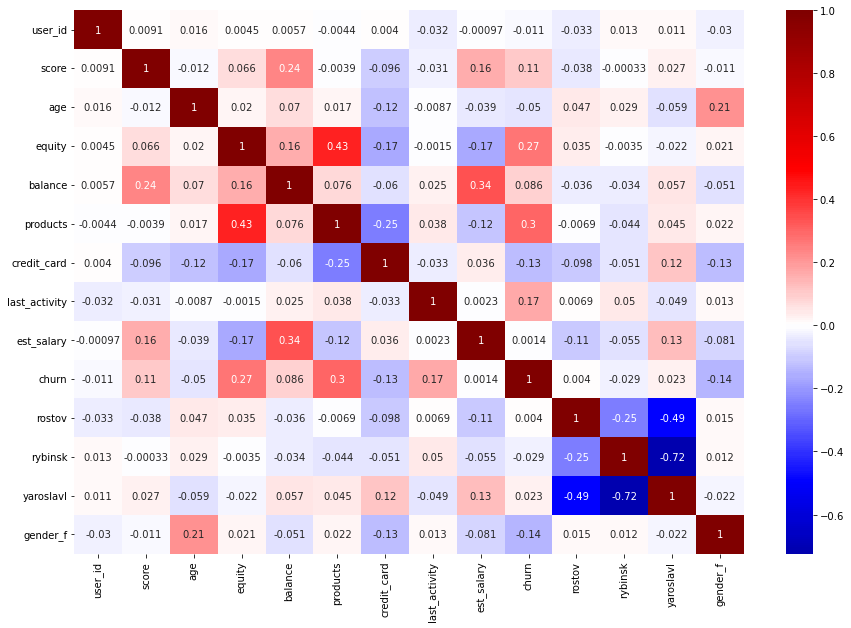

In [250]:
#Строи корреляцию и создаём хитмэп.
temp_corr = temp.iloc [:, 1:17].corr()
display(temp_corr)
plt.figure(figsize=(15,10))
sns.heatmap(temp_corr, annot=True, cmap="seismic", center = 0)
plt.show()

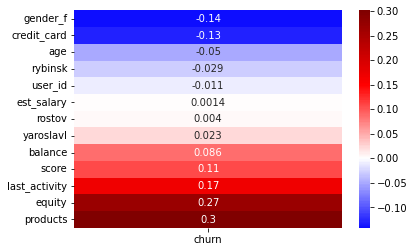

In [251]:
#выводим корреляцию признаков с оттоком.
sns.heatmap(temp_corr.loc[:, ['churn']].drop('churn').sort_values('churn'), annot=True, cmap="seismic", center = 0)
plt.show()

С оттоком в наибольшей степени коррелируют, в порядке уменьшения корреляции: products, equity, last_activity, gender_m, balance, score.
Обратная корреляция с оттоком свойственна, в порядке убывания: gender_f, credit_card.

## Проверка гипотез.
<a id="hypothesis"></a>

### Гипотеза о равенстве дохода ушедших и оставшихся клиентов банка.

Нулевая гипотеза должна быть сформулирована так, чтобы содержала положительное утверждение.
Формулируем нулевую и альтернативную гипотезы:
H0: Средние доходы ушедших и оставшихся клиентов банка равны.
H1: Средние доходы ушедших и оставшихся клиентов банка не равны.
Исходим из того, что уровень статистической значимости равен 1%, чтобы не отвергнуть каждую двадцатую гипотезу в результате ошибки.
Для проверки гипотезы используем тест для проверки равенства средних двух независимых генеральных совокупностей. Мы по сути анализируем две совокупности, одна из которых не влияет на другую.
Поскольку данный параметр имее большие выбросы в обеих группах, гипотезу стоит проверить и непараметрическим тестом Манна-Уитни.



In [252]:
#Используют двусторонний t-тест

clients_churn = temp[temp['churn'] == 1]
clients_retention = temp[temp['churn'] == 0]

salary_churn = clients_churn['est_salary']
salary_retention = clients_retention['est_salary']

alpha = .01

results = st.ttest_ind(salary_churn, salary_retention)

display('Средний доход ушедших клиентов:', round(salary_churn.mean(), 2))
display('Средний доход удержанных клиентов:', round(salary_retention.mean(), 2))

display('p-значение:', results.pvalue)

if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'Средний доход ушедших клиентов:'

148289.7

'Средний доход удержанных клиентов:'

147795.99

'p-значение:'

0.8914008969592763

'Не получилось отвергнуть нулевую гипотезу'

Средний доход удержанных клиентов практически не отличается от этого показателя для ушедших. Не получилось опровергнуть нулевую гипотезу.

In [253]:
#Применяю непараметрическй тест Манна-Уитни
alpha = .01  # критический уровень статистической значимости

results = st.mannwhitneyu(salary_churn, salary_retention)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.00023728453759153776
Отвергаем нулевую гипотезу: разница статистически значима


Непараметрический тест Манна-Уитни не подтвердил результаты t-теста. Поскольку в данных много пропусков, а сами данные содержат большой выброс, мы должны ориентироваться на результаты теста Манна-Уитни.

### Гипотеза о равенстве количества используемых продуктов ушедшими и оставшимися клиентами банка.

Формулируем нулевую и альтернативную гипотезы:
H0: Средний возраст ушедших и оставшихся клиентов одинаковый.
H1: Средний возраст ушедших и оставшихся клиентов отличается.
Исходим из того, что уровень статистической значимости равен 1%, чтобы не отвергнуть каждую двадцатую гипотезу в результате ошибки.

In [254]:
#Используют двусторонний t-тест
age_churn = clients_churn['age']
age_retention = clients_retention['age']

alpha = .01

results = st.ttest_ind(age_churn, age_retention)

display('Средий возраст ушедших клиентов:', round(age_churn.mean(), 2))
display('Средий возраст удержанных клиентов:', round(age_retention.mean(), 2))

display('p-значение:', results.pvalue)

if results.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'Средий возраст ушедших клиентов:'

41.45

'Средий возраст удержанных клиентов:'

43.02

'p-значение:'

7.065201358938971e-07

'Отвергаем нулевую гипотезу'

Тест признаёт значимой разницу в среднем возрасте удержанных и ушедших клиентов, следовательно, её влияние необходимо учитывать.

### Промежуточный итог.

На отток клиентов банка стратегически влияют: зарплата, количество недвижимости, гендерная принадлежность, кредитный рейтинг, показатели активности в пользовании услугами банка в последний месяц и пользование продуктами.
Отточными значениями и интервалами по признаку score стал интервал 830-950.

Отточными значениями и интервалами по признаку age стали: 25-38 лет и  50-61 год.

Отточным интервалом по признаку products стали: 3-5 продукта.

Отточным интервалом по признаку balance стал интервал до 2.8 млн. До максимального значения статистически значимых данных.

Отточными значениями по признаку est_salary стал интервал: 100000-500000. Остальное составляет выброс.

Отточными городами стали Ярославль (самый крупный из трёх) и Ростов.

Отточным критерием может быть отсутствие кредитной карты.

Признаком оттока можно считать активность клиента в течение последнего месяца.

## Прогнозирование оттока клиентов банка методом случайного леса.
<a id="model_creation"></a>

In [255]:
temp[temp==np.inf]=np.nan
temp.fillna(temp.mean(), inplace=True)
#делим данные на признаки (матрица X) и целевую переменную (y)


X = temp.drop(columns = ['index', 'churn', 'city', 'gender'])
y = temp['churn']


# разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

# обучаем StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# обучаем модель логистической регрессии
#model_log_regression = LogisticRegression(solver='liblinear', random_state = 0)
#model_log_regression.fit(X_train_st, y_train)

# прогнозируем отток клиентов
#log_reg_predictions = model_log_regression.predict(X_test_st)
# прогнозируем вероятность ухода клиентов в отток
#log_reg_probabilities = model_log_regression.predict_proba(X_test_st)[:, 1]

#display(log_reg_predictions)
#display(log_reg_probabilities)
#display('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, log_reg_probabilities)))

In [256]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)  # Ваш код здесь
# обучим модель случайного леса
display(temp.columns)
rf_model.fit(X_train_st, y_train)
display(temp.info())

display(rf_model.fit(X_train_st, y_train))
# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
feature_imp = pd.Series(rf_model.feature_importances_ ,index=X.columns).drop(columns = 'user_id').sort_values(ascending=False).drop(columns = 'user_id')

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st) # Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1] # Ваш код здесь

display(rf_predictions)
display(rf_probabilities)
display('Метрики для случайного леса')
display('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))
display('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities)))
display(feature_imp)

Index(['index', 'user_id', 'score', 'city', 'gender', 'age', 'equity',
       'balance', 'products', 'credit_card', 'last_activity', 'est_salary',
       'churn', 'rostov', 'rybinsk', 'yaroslavl', 'gender_f', 'gender_m'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9923 entries, 0 to 9922
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          9923 non-null   int64  
 1   user_id        9923 non-null   int64  
 2   score          9923 non-null   float64
 3   city           9923 non-null   object 
 4   gender         9923 non-null   object 
 5   age            9923 non-null   float64
 6   equity         9923 non-null   int64  
 7   balance        9923 non-null   float64
 8   products       9923 non-null   int64  
 9   credit_card    9923 non-null   int64  
 10  last_activity  9923 non-null   int64  
 11  est_salary     9923 non-null   float64
 12  churn          9923 non-null   int64  
 13  rostov         9923 non-null   uint8  
 14  rybinsk        9923 non-null   uint8  
 15  yaroslavl      9923 non-null   uint8  
 16  gender_f       9923 non-null   uint8  
 17  gender_m       9923 non-null   uint8  
dtypes: float

None

RandomForestClassifier(random_state=0)

array([1, 0, 0, ..., 1, 1, 0], dtype=int64)

array([0.79, 0.36, 0.03, ..., 0.82, 0.79, 0.14])

'Метрики для случайного леса'

'F1: 0.60'

'ROC_AUC: 0.89'

score            0.162343
balance          0.159515
user_id          0.122906
est_salary       0.120515
age              0.115117
products         0.083997
equity           0.081969
last_activity    0.058169
credit_card      0.027992
gender_f         0.015222
gender_m         0.014882
yaroslavl        0.014141
rybinsk          0.013974
rostov           0.009258
dtype: float64

Решающие признаки: score, balance, est_salary, age, products, equity, last_activity.

## Сегментирование клиентов банка.
<a id="segments"></a>


Для age, score, est_salary, products, equity, balance на основании гистограмм удержания и оттока сразу определены отточные интервалы. Для last_activity это значение 1, поскольку среди активных больше отток.

In [283]:
#Определяю отточные сегменты
segment_balance_agg = temp.query('830< score <=950 and  50<age <=61 and 400000 < balance <=2800000').agg({'churn':['count','mean']})
display('Отточный сегмент по скорингу и балансу:' ,segment_balance_agg)
segment_est_salary_agg = temp.query('830< score <=950 and 50<age <=61 and 100000 <=est_salary<= 500000').agg({'churn':['count','mean']})
display('Отточный сегмент по зарплате:' ,segment_est_salary_agg)
segment_client_activity_agg = temp.query(' 2< products <=5 and 50<age <=61 and last_activity== 1').agg({'churn':['count','mean']})
display('Отточный сегмент по клиентской активности:' ,segment_client_activity_agg)
segment_propety_agg = temp.query('2< equity <=9 and 50<age <=61 and 100000 <=est_salary<= 500000').agg({'churn':['count','mean']})
display('Отточный сегмент по баллам владения собственностью:' ,segment_propety_agg)
segment_clients_money_agg = temp.query('400000 < balance <=2800000 and 50<age <=61 and 100000 <=est_salary<= 500000').agg({'churn':['count','mean']})
display('Отточный сегмент по количеству денег у клиента:' ,segment_clients_money_agg)

'Отточный сегмент по скорингу и балансу:'

,churn
count,608.000000
mean,0.299342


'Отточный сегмент по зарплате:'

,churn
count,538.000000
mean,0.317844


'Отточный сегмент по клиентской активности:'

,churn
count,150.00
mean,0.58


'Отточный сегмент по баллам владения собственностью:'

,churn
count,416.000000
mean,0.439904


'Отточный сегмент по количеству денег у клиента:'

,churn
count,545.00000
mean,0.27156


Отточные клиенты по возрасту делятся на два интервала. Если мы объединим их в один интервал - получим четыре очень больших сегмента (2521-3331 человек отточных клиентов в каждом) с низким оттоком (26-38%) и один нормальный сегмент. Если выделять сегмент по каждому возрастному интервалу их будет восемь. Это слишком много.
Выбираем более отточный из двух возрастных интервалов - 50-61 год.
Он даёт три компактных сегмента с высоким уровнем оттока. Один очень маленький (около 150 человек), в котором отток составляет 58%. Полагаю на него тоже можно обратить внимание. Есть один сегмент, уровень оттока (31%) можно считать приемлемым.
Вместе они составляют больше 20% всех клиентов банка, что достаточно много.

В итоге получились сегменты со следующими характеристиками.
1. Сегмент, к которому относятся клиенты в возрасте 50-61 год, с высоким банковским скорингом и не большим, но заметным балансом (400 тыс. - 2.8 млн). (Назовём его условно "Кредитоспособный")
2. Сегмент, к которому относятся клиенты в возрасте 50-61 год, с с высоким банковским скорингом и высокой или очень высокой, по меркам российского региона, зарплатой (от 100 тыс. до 500 тыс.). (Назовём его условно "Зарплатный")
3. Сегмент, к которому относятся клиенты в возрасте 50-61 год, активно взаимодействующие с банком (по крайней мере - в течение последнего месяца) и пользующиеся большим количеством банковских продуктов (от 3-х до 5-и) или не пользующихся вовсе. (Назовём его условно "Активный")
4. Сегмент, к которому относятся клиенты в возрасте 50-61 год, имеющие собственность на 3-9 баллов (из 9-и), по оценке банка и получающие высокую или очень высокую, по меркам российского региона, зарплату (от 100 тыс. до 500 тыс.). (Назовём его условно "Собственники")
5. Сегмент, к которому относятся клиенты в возрасте 50-61 год, с заметным балансом на счетах (400 тыс. - 2.8 млн) и высокой или очень высокой, по меркам российского региона, зарплатой (от 100 тыс. до 500 тыс.). (Назовём его условно "Состоятельный")

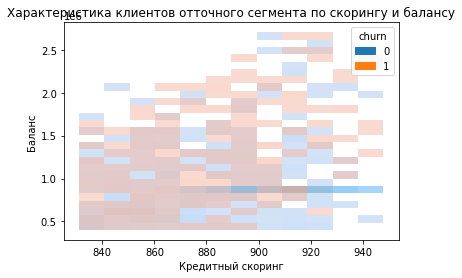

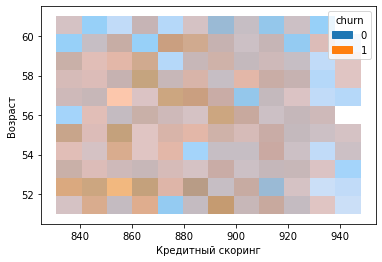

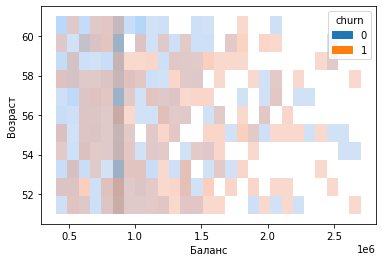

In [292]:
segment_balance = temp.query('830< score <=950 and 50<age <=61 and 400000 < balance <=2800000')

ax = sns.histplot(data=segment_balance, x="score", y="balance", hue="churn", alpha = 0.5)
plt.title('Характеристика клиентов отточного сегмента по скорингу и балансу')
plt.xlabel('Кредитный скоринг')
plt.ylabel('Баланс')
plt.show()

sns.histplot(data=segment_balance, x="score", y="age", hue="churn", alpha = 0.5)
plt.xlabel('Кредитный скоринг')
plt.ylabel('Возраст')
plt.show()

sns.histplot(data=segment_balance, x="balance", y="age", hue="churn", alpha = 0.5)
plt.xlabel('Баланс')
plt.ylabel('Возраст')
plt.show()

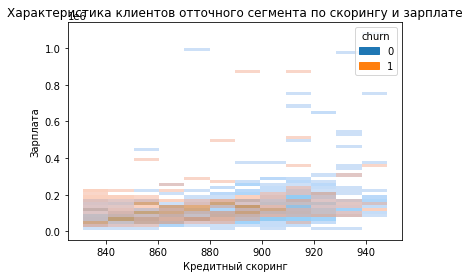

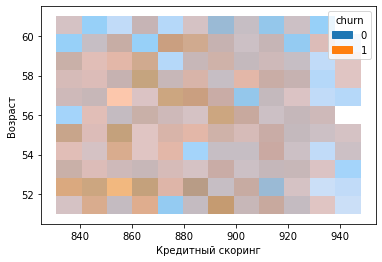

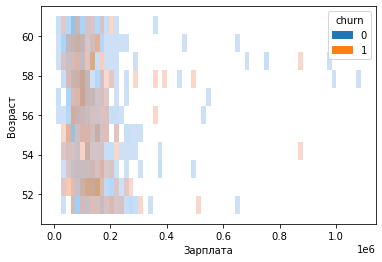

In [308]:
segment_est_salary = temp.query('830< score <=950 and 50<age <=61 and 100000 <=est_salary<= 500000')
ax = sns.histplot(data=segment_balance, x="score", y="est_salary", hue="churn", alpha = 0.5)
plt.title('Характеристика клиентов отточного сегмента по скорингу и зарплате')
plt.xlabel('Кредитный скоринг')
plt.ylabel('Зарплата')
plt.show()

sns.histplot(data=segment_balance, x="score", y="age", hue="churn", alpha = 0.5)
plt.xlabel('Кредитный скоринг')
plt.ylabel('Возраст')
plt.show()

sns.histplot(data=segment_balance, x="est_salary", y="age", hue="churn", alpha = 0.5)
plt.xlabel('Зарплата')
plt.ylabel('Возраст')
plt.show()

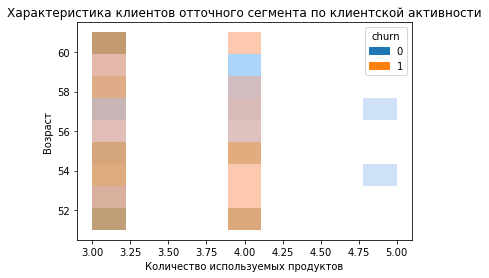

In [316]:
segment_client_activity = temp.query('2< products <=5 and 50<age <=61 and last_activity== 1')
ax = sns.histplot(data=segment_client_activity, x="products", y="age", hue="churn", alpha = 0.5)
plt.title('Характеристика клиентов отточного сегмента по клиентской активности')
plt.xlabel('Количество используемых продуктов')
plt.ylabel('Возраст')
plt.show()

Отношение параметров с last_activity выводить не стал, в виду неинформатиности графиков.

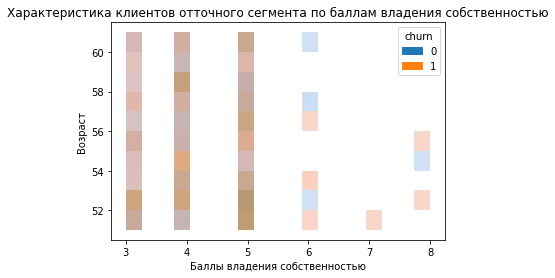

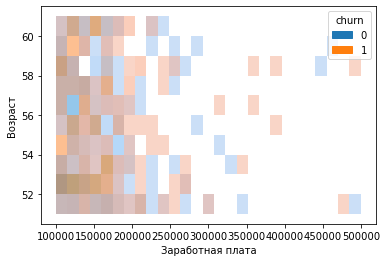

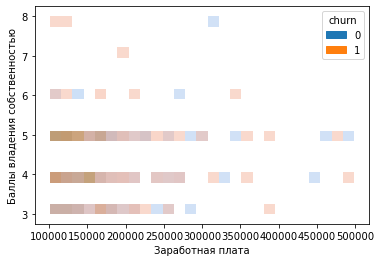

In [317]:
segment_propety = temp.query('2< equity <=9 and 50<age <=61 and 100000 <=est_salary<= 500000')

ax = sns.histplot(data=segment_propety, x="equity", y="age", hue="churn", alpha = 0.5)
plt.title('Характеристика клиентов отточного сегмента по баллам владения собственностью')
plt.xlabel('Баллы владения собственностью')
plt.ylabel('Возраст')
plt.show()

sns.histplot(data=segment_propety, x="est_salary", y="age", hue="churn", alpha = 0.5)
plt.xlabel('Заработная плата')
plt.ylabel('Возраст')
plt.show()

sns.histplot(data=segment_propety, x="est_salary", y="equity", hue="churn", alpha = 0.5)
plt.xlabel('Заработная плата')
plt.ylabel('Баллы владения собственностью')
plt.show()

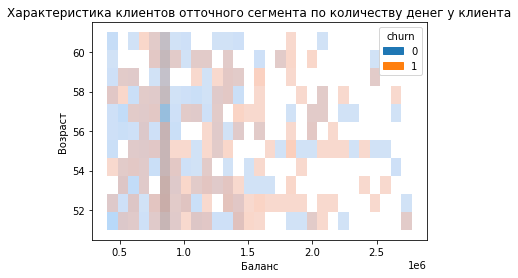

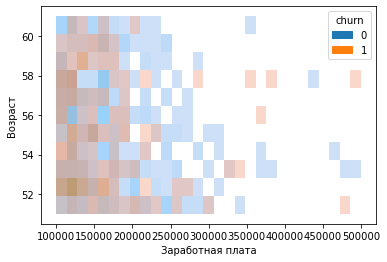

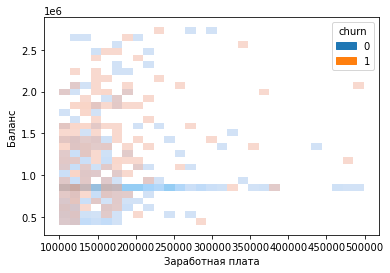

In [318]:
segment_clients_money = temp.query('400000 < balance <=2800000 and 50<age <=61 and 100000 <=est_salary<= 500000')
ax = sns.histplot(data=segment_clients_money, x="balance", y="age", hue="churn", alpha = 0.5)
plt.title('Характеристика клиентов отточного сегмента по количеству денег у клиента')
plt.xlabel('Баланс')
plt.ylabel('Возраст')
plt.show()

sns.histplot(data=segment_clients_money, x="est_salary", y="age", hue="churn", alpha = 0.5)
plt.xlabel('Заработная плата')
plt.ylabel('Возраст')
plt.show()

sns.histplot(data=segment_clients_money, x="est_salary", y="balance", hue="churn", alpha = 0.5)
plt.xlabel('Заработная плата')
plt.ylabel('Баланс')
plt.show()

## Вывод и рекомендации.
<a id="outcome"></a>

ВЫВОДЫ:
В результате анализа удалось определить самые значимые признаки клиентов банка: score, balance, est_salary, age, products, equity, last_activity. В процессе EDA удалось для всех из них найти отточные интервалы, которые и были применены при определении сегментов отточных клиентов, в отношении которых могут быть проведены маркетинговые кампании.
В результате анализа удалось определить самые значимые признаки клиентов банка: score, score, balance, est_salary, age, products, equity, last_activity. В процессе EDA удалось почти для всех из них найти отточные интервалы, которые и были применены при определении сегментов отточных, клиентов, в отношении которых могут быть проведены маркетинговые кампании.
Сегменты формировались по разным принципам. Во-первых проводилось объединение характеристик по принципу дохода(balance, est_salary, equity, last_activity). Во-вторых - по принципу пользования услугами банка (balance, products, last_activity). Третьим элементом всегда добавлялся возраст, поскольку он связан со всеми остальными признаками. Возрастной интервал 25-59 лет представляет собой объединение двух отточных интервалов по возрасту (25-43 года, ориентировочно и 49-59 лет ориентировочно), поскольку второй интервал, взятый отдельно давал бы слишком малочисленные сегменты.
В итоге получено пять отточных сегментов.
На основе EDA можно добавить, что в любом случае особое внимание должно быть уделено мужчинам. Они составляют 65% оттока.
Все отточные клиенты были разделены на пять компактных сегментов с высоким или очень высоким уровнем оттока:
1. Сегмент, к которому относятся клиенты в возрасте 50-61 год, с высоким банковским скорингом и не большим, но заметным балансом (400 тыс. - 2.8 млн). (Назовём его условно "Кредитоспособный")
2. Сегмент, к которому относятся клиенты в возрасте 50-61 год, с с высоким банковским скорингом и высокой или очень высокой, по меркам российского региона, зарплатой (от 100 тыс. до 500 тыс.). (Назовём его условно "Зарплатный")
3. Сегмент, к которому относятся клиенты в возрасте 50-61 год, активно взаимодействующие с банком (по крайней мере - в течение последнего месяца) и пользующиеся большим количеством банковских продуктов (от 3-х до 5-и). (Назовём его условно "Активный")
4. Сегмент, к которому относятся клиенты в возрасте 50-61 год, имеющие собственность на 3-9 баллов (из 9-и), по оценке банка и получающие высокую или очень высокую, по меркам российского региона, зарплату (от 100 тыс. до 500 тыс.). (Назовём его условно "Собственники")
5. Сегмент, к которому относятся клиенты в возрасте 50-61 год, с заметным балансом на счетах (400 тыс. - 2.8 млн) и высокой или очень высокой, по меркам российского региона, зарплатой (от 100 тыс. до 500 тыс.). (Назовём его условно "Состоятельный")

РЕКОМЕНДАЦИИ:
1. Для первого сегмента можно предложить выгодные условия обслуживания дебетовых карт и счетов. Уменьшить стоимость обслуживания. Предложить вклады с высоким процентом (до 10.5% годовых), открытие индивидуального инвестиционного счёта. Обеспечить индивидуальное консультирование по правовым и финансовым вопросам. Предоставить услуги бухгалтера.
2. Для второго сегмента нужно предложить зарплатную карту с бесплатным обслуживанием и снятием средств в банкоматах банка и банков-партнёров без комиссии. Либо должен быть возврат комиссии за выдачу в сторонних банкоматах. Можно предложить кэшбэк по разным видам товаров до 30% и процент на остаток до 6.5%
3. Для третьего сегмента нужно предложить личного консультанта, который ускорил и упростил бы взаимодействие клиента с банком. Лучше, ессли с таким консультантом можно связаться в мессенджере. Так же необходимо финансовое и юридическое консультирование. В том числе консультирование онлайн 24/7. Активным клиентам можно предложить благотворительную программу (по меньшей мере из двух-трёх, на выбор). Программа должна быть прозрачной, чтобы клиент видел, куда идут его деньги, видел результат деятельности организаций-получателей (помощь больным детям, строительство жилья детям-сиротам, финансирование деятельности волонтёрских организаций). Участие в программе можно поощрить адресной благодарностью от самих организаций.
4. Для четвёртого сегмента, можно предложить нефинансовые услуги: поиск и проверка арендаторов. Налоговое консультирование. Консультации по юридическим вопросам. Страхование коммерческой недвижимости. Поскольку приобретение недвижимости в России часто вид вложения средств, можно предложить в качестве варианта пассивное инвестирование посредством ETF или биржевых ПИФов.
5. Для пятого сегмента было бы полезно предложить повышенные процентные ставки по вкладам, покупку облигаций компаний, таких как РЖД или МТС, приносящих в данный момент 9.17% и 8.09%. Облигации не самое прибыльное, но самое стабильное вложение. Для людей в зрелом возрасте такой вариант может быть наиболее предпочтительным. Можно рекомендовыть ETF или биржевые ПИФы. Это пассивное инвестирование, связанное с приобретением доли в портфеле фонда, что делает такой вид инвестиций наимении рискованным.

ССЫЛКА НА ПРЕЗЕНТАЦИЮ В ФОРМАТЕ PDF.
https://drive.google.com/file/d/1hs2synAk-aW9VP4w1tSJDi97Et4yMQxi/view?usp=share_link